# Классификация вопросов на stackoverflow

## Загрузка данных


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_prefix = '/content/drive/My Drive/NLP/'
except ModuleNotFoundError:
    data_prefix = '../Datasets/SO'

Mounted at /content/drive


In [3]:
raw_train = pd.read_parquet(os.path.join(data_prefix, 'train.parquet'))

In [94]:
raw_train.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


Круговая диаграмма распределения классов в имеющейся выборке.

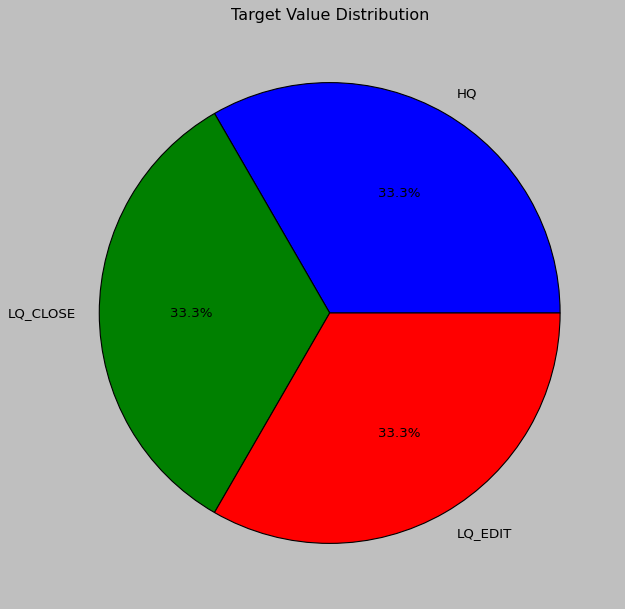

In [5]:
labels = ['HQ', 'LQ_CLOSE', 'LQ_EDIT']
values = [len(raw_train[raw_train['target'] == 0]),
          len(raw_train[raw_train['target'] == 1]),
          len(raw_train[raw_train['target'] == 2])]
plt.style.use('classic')
plt.figure(figsize=(16, 9))
plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Target Value Distribution")
plt.show()

Вывод: классы в нашей выборке распределены равномерно.

## Разделение данных на тренировочную и валидационную выборки 


In [95]:
raw_target = raw_train['target']
raw_data   = raw_train.drop(['target'], axis = 1)

In [7]:
raw_target.head()

Id
34862324    2
47303682    2
46431243    0
45306324    0
49479547    1
Name: target, dtype: int64

In [8]:
raw_data.head()

,Body,Tags,Title
Id,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,..."
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...


In [96]:
train_data, test_data, train_target, test_target = train_test_split(raw_data, raw_target,
                                                                    test_size=0.25, random_state=47)

In [97]:
print('Training Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape:  (36000, 3)
Test Data Shape:  (12000, 3)


In [11]:
[len(train_target[train_target == 0]),
 len(train_target[train_target == 1]),
 len(train_target[train_target == 2])]

[12029, 12032, 11939]

In [12]:
train_data.head()

,Body,Tags,Title
Id,,,
41452608,"df <- data.frame(id = c(1, 1, 2, 2, 2), desc =...",<r><dplyr>,R dplyr - count and select first row by group
39823020,<p>Can anyone tell what could be the solution ...,<java><android><ads>,AdMob ads in app not working on some devices
52003167,"<p>Let's say i have <code>a=[1,0,1,0,1,1,1,0,0...",<python><python-3.x>,How to remove more than one elements from list...
38850633,<p>I am new in ios development. I have created...,<ios><app-store>,App submission with coming soon alert
54208043,<p>I want to change the default colors (curren...,<r><ggplot2>,How to change default color of points in ggplo...


In [13]:
test_data.head()

,Body,Tags,Title
Id,,,
51918932,<p>the question can maybe be stupid but did no...,<laravel><npm><assets><node-modules><selectize...,How to properly include a library from node_mo...
46068744,I am porting unity game to universal windows p...,<c#><unity3d><uwp><visual-studio-2017><build-e...,Getting error in compiling Unity Universal Win...
36958873,I just did an upgrade from CRM 2011 to CRM 201...,<html><dynamics-crm-2015>,crm 2015 unsupported line of code - HTML Resource
57230064,"I have a list of items and for some purpose, I...",<android><android-fragments><android-recyclerv...,java.lang.IndexOutOfBoundsException: Invalid i...
51532513,******************** The html string is. *****...,<ios><swift><webview>,ios how to show htmlString into webview the ht...


## Предварительная обработка данных

Реализуем методы, с помощью которых будем пытаться повысить точность моделей на наших данных. 


1.   Удаление HTML тэгов
2.   Удаление всех символов, кроме латиницы и пробелов
3.   Токенизация слов (с использованием библиотеки nltk)
4.   Удаление "стоп-слов"



In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
import re 

from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup


def remove_html_tags(html):
    return BeautifulSoup(html).get_text()


def stay_only_a_z(text):
    text = re.sub(r'[^a-zA-Z\s]','', text)
    return text


def tokenize_by_word(text):
    return ' '.join(__word_punct_tokenizer.tokenize(text))


def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word.lower() not in __stop_words])

__word_punct_tokenizer = WordPunctTokenizer()
__stop_words = stopwords.words('english')

### Демонстрация работы алгоритмов предобработки

In [19]:
remove_html_tags('''
<p>I am using nltk. However, I've just got up to the method like</p>

<pre><code>my_text = ['This', 'is', 'my', 'text']
</code></pre>

<p>I'd like to discover any way to input my "text" as:</p>

<pre><code>my_text = "This is my text, this is a nice way to input text."
</code></pre>
''')

'I am using nltk. However, I\'ve just got up to the method like\nmy_text = [\'This\', \'is\', \'my\', \'text\']\n\nI\'d like to discover any way to input my "text" as:\nmy_text = "This is my text, this is a nice way to input text."\n\n'

In [20]:
stay_only_a_z("(A)lgorithmm:\r\n\r\n**input :** Graph G\r\n\r\n**output:** Set of MSTs T\r\n\r\n**begin*")

'Algorithmm\r\n\r\ninput  Graph G\r\n\r\noutput Set of MSTs T\r\n\r\nbegin'

In [21]:
tokenize_by_word("(A)lgorithmm:\r\n\r\n**input :** Graph G\r\n\r\n**output:** Set of MSTs T\r\n\r\n**begin*")

'( A ) lgorithmm : ** input :** Graph G ** output :** Set of MSTs T ** begin *'

In [22]:
remove_stop_words(
    tokenize_by_word('Algorithmm :  you\'d, your, yours, yourself, yourselves, he, him,   ** input :** '))

"Algorithmm : ' , , , , , , , ** input :**"

### Выполнение предобработки

Объединим реализованные ранее методы в единый метод body_preprocess. 

*Примечание: закомментированные методы показали ухудшение результатов в процессе тестирования.*

In [24]:
def body_preprocess(text):
    #text = remove_html_tags(text)
    text = stay_only_a_z(text)
    text = tokenize_by_word(text)
    #text = remove_stop_words(text)
    return text.lower()

Демонстрация на тестовом фрагменте:

In [25]:
body_preprocess('''
Algorithmm:

**input :** Graph G

**output:** Set of MSTs T

**begin**

T=null;
E=G.Edges;

for all vertices in G,
Create a tree t having single vertex b

add t to T

end for

     repeat
        Find an edge e ∈ E having minimum weight
        such that one end belongs to t ∈ T and the other
        end does not belongs to any of the trees in T
        Add e to t
      until e = NULL

I'm stuck on the logic for the highlighted block.
I've used simple objects for vertex,edge and tree. And for their sets, used array of Objects.''')

'algorithmm input graph g output set of msts t begin tnull egedges for all vertices in g create a tree t having single vertex b add t to t end for repeat find an edge e e having minimum weight such that one end belongs to t t and the other end does not belongs to any of the trees in t add e to t until e null im stuck on the logic for the highlighted block ive used simple objects for vertexedge and tree and for their sets used array of objects'

#### Препроцессинг для Body

In [98]:
train_data['Body'] = train_data['Body'].apply(body_preprocess)
test_data ['Body'] = test_data ['Body'].apply(body_preprocess)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
train_data.head()

,Body,Tags,Title
Id,,,
41452608,df dataframeid c desc ca a b b b i would like ...,<r><dplyr>,R dplyr - count and select first row by group
39823020,pcan anyone tell what could be the solution of...,<java><android><ads>,AdMob ads in app not working on some devices
52003167,plets say i have codeacodep p i want to remove...,<python><python-3.x>,How to remove more than one elements from list...
38850633,pi am new in ios development i have created on...,<ios><app-store>,App submission with coming soon alert
54208043,pi want to change the default colors currently...,<r><ggplot2>,How to change default color of points in ggplo...


#### Препроцессинг для Title

Выполнен по аналогии с body_preprocess, но использовался другой набор методов.

In [91]:
def title_preprocessing(text):
    text = stay_only_a_z(text)
    text = tokenize_by_word(text)
    return text.lower()

In [100]:
train_data['Title'] = train_data['Title'].apply(title_preprocessing)
test_data ['Title'] = test_data ['Title'].apply(title_preprocessing)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [101]:
train_data.head()

,Body,Tags,Title
Id,,,
41452608,df dataframeid c desc ca a b b b i would like ...,<r><dplyr>,r dplyr count and select first row by group
39823020,pcan anyone tell what could be the solution of...,<java><android><ads>,admob ads in app not working on some devices
52003167,plets say i have codeacodep p i want to remove...,<python><python-3.x>,how to remove more than one elements from list...
38850633,pi am new in ios development i have created on...,<ios><app-store>,app submission with coming soon alert
54208043,pi want to change the default colors currently...,<r><ggplot2>,how to change default color of points in ggplo...


## Определение исходных фич

Была проведена попытка объединить заголовок и текст вопроса.

Предлагается также исключить из рассмотрения раздел тэгов.


In [31]:
def get_raw_features(__data):
    __data['text'] = __data['Title'] + ' ' + __data['Body']
    return __data.drop(['Tags', 'Title', 'Body'], axis=1)

In [102]:
train_data = get_raw_features(train_data)
test_data = get_raw_features(test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
train_data.head()

,text
Id,
41452608,r dplyr count and select first row by group df...
39823020,admob ads in app not working on some devices p...
52003167,how to remove more than one elements from list...
38850633,app submission with coming soon alert pi am ne...
54208043,how to change default color of points in ggplo...


In [104]:
test_data.head()

,text
Id,
51918932,how to properly include a library from nodemod...
46068744,getting error in compiling unity universal win...
36958873,crm unsupported line of code html resource i j...
57230064,javalangindexoutofboundsexception invalid inde...
51532513,ios how to show htmlstring into webview the ht...


In [105]:
train_data = train_data['text']
test_data = test_data['text']

train_target = train_target.values
test_target  = test_target.values

## Решение задачи классическими методами

### Классические методы векторизации данных

#### 1. BOW (Bag of words)

In [36]:
def bow(train, test):
    bow_vectorizer = CountVectorizer()
    train_vec = bow_vectorizer.fit_transform(train)
    test_vec = bow_vectorizer.transform(test)
    return train_vec, test_vec

#### 2. tf-idf

In [37]:
def tf_idf(train, test):
    tfidf_vectorizer = TfidfVectorizer()
    train_vec = tfidf_vectorizer.fit_transform(train)
    test_vec = tfidf_vectorizer.transform(test)

    return train_vec, test_vec

### Построение классических классификаторов


#### 1. k Nearest Neighbors (kNN)

In [38]:
def knn_score(trainX, trainY, testX, testY):
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(trainX, trainY)
    return knn_classifier.score(testX, testY)

#### 2. Random Forests

In [39]:
def random_forest_score(trainX, trainY, testX, testY):
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(trainX, trainY)
    return rf_classifier.score(testX, testY)

#### 3. Логистическая регрессия

In [40]:
def lr_score(trainX, trainY, testX, testY):
    lr_classifier = LogisticRegression()
    lr_classifier.fit(trainX, trainY)
    return lr_classifier.score(testX, testY)

In [41]:
def visualize_results(score):
    print(score)

def base_pipeline(train_x, train_y, test_x, test_y,
                  vectorizer, scorer):
    vectorized_train_x, vectorized_test_x = vectorizer(train_x, test_x)
    score = scorer(vectorized_train_x, train_y, vectorized_test_x, test_y)
    visualize_results(score)

### Оценка качества классификаторов

1. BOW + Linear Regression

In [42]:
base_pipeline(train_data, train_target, test_data, test_target,
              bow, lr_score)

0.8831666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2. BOW + kNN

In [43]:
base_pipeline(train_data, train_target, test_data, test_target,
              bow, knn_score)

0.49683333333333335


3. BOW + Random Forests

In [44]:
base_pipeline(train_data, train_target, test_data, test_target,
              bow, random_forest_score)

0.82925


4. tf-idf + kNN

In [45]:
base_pipeline(train_data, train_target, test_data, test_target,
              tf_idf, knn_score)

0.577


5. tf-idf + Random Forests

In [46]:
base_pipeline(train_data, train_target, test_data, test_target,
              tf_idf, random_forest_score)

0.8310833333333333


6. tf-idf + Linear Regression

In [47]:
base_pipeline(train_data, train_target, test_data, test_target,
              tf_idf, lr_score)

0.8795


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Полученные результаты сведем в таблицу:

Тип | BOW | tf-idf
:----- | :----: | -----:
**kNN**   | 0.50 | 0.58
**Random Forest**  | 0.83  | 0.83
**Linear Regression**  | 0.88  | 0.88




Наилучший результат (score = 0.88) получили при использовании линейной регрессии.

## Использование предобученных эмбеддингов для векторизации

### Векторизация с использованием w2v

Первая версия модели, от Google, обученная на новостных данных.

In [58]:
import gensim.downloader as api
word2vec_model300 = api.load('word2vec-google-news-300')
word2vec_model300['upload']

[=================================================-] 100.0% 1662.6/1662.8MB downloaded


array([-0.08251953, -0.03393555, -0.05200195,  0.08691406,  0.04663086,
        0.10205078,  0.11523438,  0.14941406,  0.07617188, -0.02319336,
       -0.28515625,  0.06298828, -0.06591797,  0.08105469, -0.18261719,
        0.34765625,  0.25390625,  0.21386719, -0.03833008, -0.20800781,
       -0.01513672,  0.05859375, -0.31054688,  0.3125    , -0.046875  ,
       -0.21386719,  0.09960938, -0.140625  ,  0.13964844, -0.31445312,
       -0.25      , -0.00430298, -0.02282715, -0.15625   , -0.19921875,
       -0.33398438,  0.00476074, -0.20996094,  0.18164062,  0.16015625,
       -0.11425781,  0.23535156,  0.31445312,  0.15722656,  0.01086426,
       -0.2890625 , -0.08105469,  0.12988281,  0.0213623 , -0.0625    ,
       -0.17871094, -0.30859375,  0.26953125, -0.16308594, -0.00300598,
       -0.01782227, -0.05444336,  0.05200195, -0.20507812,  0.31445312,
        0.48828125, -0.16601562, -0.23828125, -0.16992188, -0.1484375 ,
        0.05541992, -0.19140625,  0.00189209,  0.26171875,  0.34

Вторая модель w2v, обученная на данных StaskOverflow. Попробуем использовать её и сравнить с оригинальной от Google. Гипотеза заключается в том, что на stackoverflow версии точность предсказания должна быть выше, поскольку он был обучен на схожей с нашей выборке.

In [70]:
from gensim.models.keyedvectors import KeyedVectors
so_w2v = KeyedVectors.load_word2vec_format(os.path.join(data_prefix, "SO_vectors_200.bin"), binary=True)

In [12]:
def get_w2v_str_representation_mean(text, model):
    words = text.split()
    words_representation = [model[word] for word in words if word in model.vocab]
    return np.mean(words_representation, axis=0)

def get_w2v_str_representation_sum(text, model):
    words = text.split()
    words_representation = [model[word] for word in words if word in model.vocab]
    return np.sum(words_representation, axis=0)

Проверим работоспособность на тестовой строке.

In [77]:
w2v_test_str = 'algorithmm input graph g output set of msts t begin tnull egedges for all vertices in g create a tree t having single vertex b add t to t end for repeat find an edge e e having minimum weight such that one end belongs to t t and the other end does not belongs to any of the trees in t add e to t until e null im stuck on the logic for the highlighted block ive used simple objects for vertexedge and tree and for their sets used array of objects'

In [76]:
print(get_w2v_str_representation_sum(w2v_test_str, so_w2v)[:10])
print(get_w2v_str_representation_sum(w2v_test_str, word2vec_model300)[:10])

[  8.154484  12.033579 -41.343773  38.206593 -77.40206   46.77203
  28.464117  15.215707 -20.109539  -9.964755]
[-1.1984253  3.0158386  1.1643982  8.2055855 -7.5487366 -1.7441101
  1.474762  -5.4065857  4.599365   4.1917725]


In [78]:
def w2v_vectorizer_sum_news(train, test):
    return ([get_w2v_str_representation_sum(text, word2vec_model300) for text in train],
            [get_w2v_str_representation_sum(text, word2vec_model300) for text in test])

def w2v_vectorizer_mean_news(train, test):
    return ([get_w2v_str_representation_mean(text, word2vec_model300) for text in train],
            [get_w2v_str_representation_mean(text, word2vec_model300) for text in test])

def w2v_vectorizer_sum_so(train, test):
    return ([get_w2v_str_representation_sum(text, so_w2v) for text in train],
            [get_w2v_str_representation_sum(text, so_w2v) for text in test])

def w2v_vectorizer_mean_so(train, test):
    return ([get_w2v_str_representation_mean(text, so_w2v) for text in train],
            [get_w2v_str_representation_mean(text, so_w2v) for text in test])


### Векторизация с использованием Doc2Vec

In [82]:
from gensim.models.doc2vec import Doc2Vec

d2v_model= Doc2Vec.load(os.path.join(data_prefix, "doc2vec.bin"))

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [89]:
def d2v_vectorizer(train, test):
    return ([d2v_model.infer_vector([text]) for text in train],
            [d2v_model.infer_vector([text]) for text in test])

### Проверка точности

Будем использовать линейную регрессию, которая ранее показала наилучший результат на других методах векторизации.

In [84]:
base_pipeline(train_data, train_target, test_data, test_target,
              w2v_vectorizer_sum_news, lr_score)

0.7115


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [85]:
base_pipeline(train_data, train_target, test_data, test_target,
              w2v_vectorizer_mean_news, lr_score)

0.7126666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [86]:
base_pipeline(train_data, train_target, test_data, test_target,
              w2v_vectorizer_sum_so, lr_score)

0.7144166666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [87]:
base_pipeline(train_data, train_target, test_data, test_target,
              w2v_vectorizer_mean_so, lr_score)

0.7256666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [90]:
base_pipeline(train_data, train_target, test_data, test_target,
              d2v_vectorizer, lr_score)

0.3288333333333333


На предобученных эмбеддингах наилучший результат (score = 0.725) получился при использовании w2v, обученного с использованием данных stackoverflow, что подтверждает высказанную ранее гипотезу о его преимуществе над стандартным от Google в условиях нашей задачи. 

## Обучение своего w2v эмбеддинга 

Проведем попытку обучить собственный w2v эмбеддинг, попытаемся увеличить точность относительно использованного ранее.

In [106]:
def get_sentences(series_data):
    list_of_lists_data = [i.split() for i in series_data]
    return list_of_lists_data

In [107]:
from gensim.models import Word2Vec
sentences = get_sentences(train_data.append(test_data))

try:
    our_w2v_model = Word2Vec.load("own_w2v")
except Exception:
    our_w2v_model = Word2Vec(min_count=1)
    our_w2v_model.build_vocab(sentences)  # prepare the model vocabulary
    our_w2v_model.train(sentences, total_examples=our_w2v_model.corpus_count, epochs=our_w2v_model.iter)  # train word vectors
    our_w2v_model.save("own_w2v")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if __name__ == '__main__':


In [110]:
def get_w2v_str_representation_mean(text, model):
    words = text.split()
    words_representation = [model[word] for word in words if word in model.wv.vocab]
    return np.mean(words_representation, axis=0)

def get_w2v_str_representation_sum(text, model):
    words = text.split()
    words_representation = [model[word] for word in words if word in model.wv.vocab]
    return np.sum(words_representation, axis=0)

def our_w2v_vectorizer_sum(train, test):
    return ([get_w2v_str_representation_sum(text, our_w2v_model) for text in train],
            [get_w2v_str_representation_sum(text, our_w2v_model) for text in test])

def our_w2v_vectorizer_mean(train, test):
    return ([get_w2v_str_representation_mean(text, our_w2v_model) for text in train],
            [get_w2v_str_representation_mean(text, our_w2v_model) for text in test])

In [111]:
base_pipeline(train_data, train_target, test_data, test_target,
              our_w2v_vectorizer_sum, lr_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


0.7949166666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [112]:
base_pipeline(train_data, train_target, test_data, test_target,
              our_w2v_vectorizer_mean, lr_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


0.8065


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Благодаря обучению собственного эмбеддинга удалось увеличить точность до 0.8065. 

## Использование нейронной сети

### Предварительная обработка данных для нейронной сети

In [4]:
text_columns = ["Title", "Body"]
categorical_columns = ['Tags']
target_column = 'target'

In [10]:
nn_train = raw_train
nn_train["Body"] = nn_train["Body"].apply(str).apply(str.lower).apply(tokenize_by_word)
nn_train["Title"] = nn_train["Title"].apply(str).apply(str.lower).apply(tokenize_by_word)

In [15]:
nn_train['target'] = nn_train['target'].apply(lambda target: np.eye(3, dtype=np.int32)[target])

In [17]:
from collections import Counter
token_counts = Counter(token for col in text_columns
                             for item in nn_train[col]
                             for token in item.split())

In [18]:
print("Число уникальных токенов:", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))


Число уникальных токенов: 230236
('.', 543501)
('>', 375572)
('p', 225299)
('<', 215383)
(',', 202492)
...
('3bujt', 1)
('9i4jf', 1)
('__nscfarray', 1)


Построим гистограмму распределения числа слов в каждом счетчике.

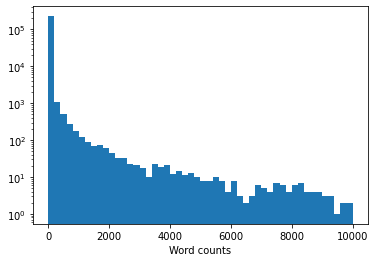

In [19]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Отфильтруем токены, которые встречаются как минимум 10 раз.

In [20]:
tokens = [token for token, count in token_counts.items() if count >= 10]

Введем специальные токены для unknown и пустых слов.

In [21]:
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 24477


In [22]:
token_to_id = dict(map(reversed, enumerate(tokens)))

In [23]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

### Построение модели нейронной сети

In [24]:
from sklearn.model_selection import train_test_split

nn_data_train, nn_data_val = train_test_split(nn_train, test_size=0.2, random_state=25)
nn_data_train.index = range(len(nn_data_train))
nn_data_val.index = range(len(nn_data_val))

print("Train size = ", len(nn_data_train))
print("Validation size = ", len(nn_data_val))

Train size =  38400
Validation size =  9600


In [25]:
def convert_array(arr):
  result = np.zeros((len(arr), 3),dtype=np.int32)
  for i in range(len(arr)):
    for j in range(len(arr[i])):
      result[i, j] = arr[i][j]
  return result

In [38]:
from sklearn.feature_extraction import DictVectorizer

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(nn_train[categorical_columns].apply(dict, axis=1))

top_types, top_counts = zip(*Counter(nn_train['Tags']).most_common(1000))
recognized_companies = set(top_types)

In [28]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["Body"] = as_matrix(data["Body"].values, max_len)
    batch["target"] = convert_array(data["target"].values)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["Body"] = apply_word_dropout(batch["Body"], 1. - word_dropout)
    
    # if target_column in data.columns:
    if target_column in ['Title', 'Body', 'Categorical']:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

{'a': convert_array(nn_train[:3]["target"].values)}
make_batch(nn_data_train[:3], max_len=10)

{'Body': array([[ 3378, 16759,  3569, 12276, 23884, 14037, 22100,  7886,  4180,
         12272],
        [12276,   406, 14411, 22437, 22100,  7886,  4180,  7705, 22100,
         20958],
        [ 3378, 17586,  3656,  7071,  3569, 21015,  4202,  3412,     0,
          1304]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Title': array([[12153, 22100,  7886,  4180, 12272, 12538, 10683, 23721,  3703,
             1],
        [ 7886,  4843, 20958,  7707, 16297, 16374,  9047,   639,  9340,
           903],
        [21857,  8346, 18811,  6321, 21857, 21015, 13070, 15980, 21292,
          4843]], dtype=int32),
 'target': array([[1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]], dtype=int32)}

In [29]:
import keras
import keras.layers as L
from keras.backend import int_shape, expand_dims

In [30]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="Body")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
      
    l_title_emb = L.Embedding(n_tokens, 64)(l_title)
    l_title_emb = L.GlobalMaxPool1D()(l_title_emb)

    l_descr_emb = L.Embedding(n_tokens, 64)(l_descr)
    l_descr_emb = L.GlobalMaxPool1D()(l_descr_emb)
    l_descr_emb = L.Dense(128)(l_descr_emb)
    
    l_cat_emb = L.Dense(128)(l_categ)

    l_all = L.Concatenate()([l_cat_emb, l_descr_emb, l_title_emb])

    l_all = expand_dims(l_all, 1)
    l_all = L.Conv1D(64, 5, activation='relu', padding='same')(l_all)
    l_all = L.GlobalMaxPool1D()(l_all)

    l_all = expand_dims(l_all, 1)
    l_all = L.Conv1D(128, 3, activation='relu', padding='same')(l_all)
    l_all = L.GlobalMaxPool1D()(l_all)

    l_all = L.Dense(64)(l_all)
    
    output_layer = L.Dense(3)(l_all)
    output_layer = L.Softmax()(output_layer)
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [31]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(nn_data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(nn_data_train[:100]), convert_array(nn_data_train['target'][:100]))[0]

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     1566528     Body[0][0]                       
__________________________________________________________________________________________________
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
Categorical (InputLayer)        [(None, 27249)]      0                                            
_______________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [32]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Обучение нейронной сети

In [33]:
batch_size = 256
epochs = 5 
steps_per_epoch = 100 

model = build_model()

model.fit_generator(iterate_minibatches(nn_data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(nn_data_val, batch_size, cycle=True),
                    validation_steps=nn_data_val.shape[0]
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
100/100 [==============================] - 645s 6s/step - loss: 0.6019 - categorical_accuracy: 0.7214 - val_loss: 0.2515 - val_categorical_accuracy: 0.8904
Epoch 2/5
100/100 [==============================] - 637s 6s/step - loss: 0.1670 - categorical_accuracy: 0.9347 - val_loss: 0.2148 - val_categorical_accuracy: 0.9124
Epoch 3/5
100/100 [==============================] - 634s 6s/step - loss: 0.0970 - categorical_accuracy: 0.9670 - val_loss: 0.2086 - val_categorical_accuracy: 0.9145
Epoch 4/5
100/100 [==============================] - 632s 6s/step - loss: 0.0408 - categorical_accuracy: 0.9860 - val_loss: 0.2139 - val_categorical_accuracy: 0.9174
Epoch 5/5
100/100 [==============================] - 631s 6s/step - loss: 0.0323 - categorical_accuracy: 0.9884 - val_loss: 0.2399 - val_categorical_accuracy: 0.9162


Используя нейронную сеть удалось достичь точности в 0.9162.
Это наилучший результат из достигнутых.

Тестовый набор данных будем классифицировать с её помощью.

## Формирование ответа

In [46]:
raw_test = pd.read_parquet(os.path.join(data_prefix, 'test.parquet'))
nn_test = raw_test
nn_test["Body"] = raw_test["Body"].apply(str).apply(str.lower).apply(tokenize_by_word)
nn_test["Title"] = raw_test["Title"].apply(str).apply(str.lower).apply(tokenize_by_word)

nn_test["Tags"] = nn_test["Tags"].apply(lambda comp: comp if comp in recognized_companies else "Other")

In [39]:
def make_test_batch(data, max_len=None, word_dropout=0):

    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["Body"] = as_matrix(data["Body"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    

    if target_column in ['Title', 'Body', 'Categorical']:
        batch[target_column] = data[target_column].values
    
    return batch

In [ ]:
pred = model.predict(make_test_batch(nn_test))

In [ ]:
pred = list(map(np.argmax, pred))

In [ ]:
answer = pd.DataFrame(data={'Id':test_pr.index.tolist(), 'Predicted': pred})

In [ ]:
answer

In [ ]:
answer.to_csv("result.csv", index=False)